# March Madness Box Score Data Analyzer

This notebook provides a comprehensive analysis of NCAA Men's Basketball team box scores from 2003-2023. We'll explore team performance, statistics, and trends across multiple seasons.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import glob
import os
from pathlib import Path
import warnings

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 1.26.4
Current working directory: /users/bzheng2/Private/March-Madness-Predictor


## Data Loading Functions

Let's create functions to efficiently load and work with the compressed CSV files.

In [2]:
class BoxScoreAnalyzer:
    """A class for analyzing NCAA basketball box score data."""
    
    def __init__(self, data_dir="data/csv"):
        self.data_dir = Path(data_dir)
        self.available_years = self._get_available_years()
        self.data_cache = {}
        print(f"Found data for years: {sorted(self.available_years)}")
    
    def _get_available_years(self):
        """Get list of available years from CSV files."""
        csv_files = glob.glob(str(self.data_dir / "team_box_*.csv.gz"))
        years = []
        for file in csv_files:
            year = int(file.split('_')[-1].split('.')[0])
            years.append(year)
        return years
    
    def load_year_data(self, year):
        """Load data for a specific year."""
        if year not in self.available_years:
            raise ValueError(f"Year {year} not available. Available years: {self.available_years}")
        
        if year in self.data_cache:
            return self.data_cache[year]
        
        file_path = self.data_dir / f"team_box_{year}.csv.gz"
        print(f"Loading data for {year}...")
        
        with gzip.open(file_path, 'rt') as f:
            df = pd.read_csv(f)
        
        # Parse datetime columns
        if 'game_date' in df.columns:
            df['game_date'] = pd.to_datetime(df['game_date'])
        if 'game_date_time' in df.columns:
            df['game_date_time'] = pd.to_datetime(df['game_date_time'])
        
        self.data_cache[year] = df
        print(f"Loaded {len(df)} records for {year}")
        return df
    
    def load_multiple_years(self, years):
        """Load data for multiple years and combine."""
        dfs = []
        for year in years:
            df = self.load_year_data(year)
            dfs.append(df)
        
        combined = pd.concat(dfs, ignore_index=True)
        print(f"Combined data: {len(combined)} total records across {len(years)} years")
        return combined
    
    def load_all_data(self):
        """Load all available data."""
        return self.load_multiple_years(self.available_years)

# Initialize the analyzer
analyzer = BoxScoreAnalyzer()

# Load a sample year to explore the structure
sample_data = analyzer.load_year_data(2023)
print(f"\nSample data shape: {sample_data.shape}")
print(f"Columns: {len(sample_data.columns)}")
print("\nColumns:")
print(sample_data.columns[:].tolist())

Found data for years: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Loading data for 2023...
Loaded 12370 records for 2023

Sample data shape: (12370, 54)
Columns: 54

Columns:
['game_id', 'season', 'season_type', 'game_date', 'game_date_time', 'team_id', 'team_uid', 'team_slug', 'team_location', 'team_name', 'team_abbreviation', 'team_display_name', 'team_short_display_name', 'team_color', 'team_alternate_color', 'team_logo', 'team_home_away', 'team_score', 'team_winner', 'assists', 'blocks', 'defensive_rebounds', 'field_goal_pct', 'field_goals_made', 'field_goals_attempted', 'flagrant_fouls', 'fouls', 'free_throw_pct', 'free_throws_made', 'free_throws_attempted', 'largest_lead', 'offensive_rebounds', 'steals', 'team_turnovers', 'technical_fouls', 'three_point_field_goal_pct', 'three_point_field_goals_made', 'three_point_field_goals_attempted', 'total_rebounds', 'total_technical_fouls', 'total_turnovers',

## Data Exploration Functions

Let's explore the structure and content of our data to understand what we're working with.

In [3]:
def explore_data_structure(df):
    """Comprehensive exploration of data structure."""
    print("=" * 60)
    print("DATA STRUCTURE OVERVIEW")
    print("=" * 60)
    
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\n" + "="*50)
    print("COLUMN INFORMATION")
    print("="*50)
    
    # Group columns by category
    team_info_cols = [col for col in df.columns if col.startswith('team_') and not col.startswith('team_score')]
    opponent_cols = [col for col in df.columns if col.startswith('opponent_')]
    stat_cols = [col for col in df.columns if col not in team_info_cols + opponent_cols 
                 and col not in ['game_id', 'season', 'season_type', 'game_date', 'game_date_time']]
    
    print(f"\nTeam Information Columns ({len(team_info_cols)}):")
    for i, col in enumerate(team_info_cols):
        print(f"  {i+1:2d}. {col}")
    
    print(f"\nOpponent Information Columns ({len(opponent_cols)}):")
    for i, col in enumerate(opponent_cols):
        print(f"  {i+1:2d}. {col}")
    
    print(f"\nStatistical Columns ({len(stat_cols)}):")
    for i, col in enumerate(stat_cols):
        print(f"  {i+1:2d}. {col}")
    
    return {
        'team_info': team_info_cols,
        'opponent_info': opponent_cols,
        'statistics': stat_cols
    }

def analyze_missing_data(df):
    """Analyze missing data patterns."""
    print("\n" + "="*50)
    print("MISSING DATA ANALYSIS")
    print("="*50)
    
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    }).sort_values('Missing Count', ascending=False)
    
    missing_cols = missing_df[missing_df['Missing Count'] > 0]
    
    if len(missing_cols) > 0:
        print(f"Columns with missing data: {len(missing_cols)}")
        print(missing_cols)
    else:
        print("No missing data found!")
    
    return missing_df

def analyze_data_types(df):
    """Analyze data types and distributions."""
    print("\n" + "="*50)
    print("DATA TYPES ANALYSIS")
    print("="*50)
    
    # Group by data type
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    string_cols = df.select_dtypes(include=['object']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
    
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"String columns: {len(string_cols)}")
    print(f"Datetime columns: {len(datetime_cols)}")
    
    if numeric_cols:
        print(f"\nNumeric columns sample:")
        print(df[numeric_cols[:5]].describe().round(2))
    
    return {
        'numeric': numeric_cols,
        'string': string_cols,
        'datetime': datetime_cols
    }

# Run comprehensive data exploration
print("Exploring 2023 data structure...")
column_groups = explore_data_structure(sample_data)
missing_analysis = analyze_missing_data(sample_data)
type_analysis = analyze_data_types(sample_data)

Exploring 2023 data structure...
DATA STRUCTURE OVERVIEW
Shape: (12370, 54)
Memory usage: 18.60 MB

COLUMN INFORMATION

Team Information Columns (14):
   1. team_id
   2. team_uid
   3. team_slug
   4. team_location
   5. team_name
   6. team_abbreviation
   7. team_display_name
   8. team_short_display_name
   9. team_color
  10. team_alternate_color
  11. team_logo
  12. team_home_away
  13. team_winner
  14. team_turnovers

Opponent Information Columns (12):
   1. opponent_team_id
   2. opponent_team_uid
   3. opponent_team_slug
   4. opponent_team_location
   5. opponent_team_name
   6. opponent_team_abbreviation
   7. opponent_team_display_name
   8. opponent_team_short_display_name
   9. opponent_team_color
  10. opponent_team_alternate_color
  11. opponent_team_logo
  12. opponent_team_score

Statistical Columns (23):
   1. team_score
   2. assists
   3. blocks
   4. defensive_rebounds
   5. field_goal_pct
   6. field_goals_made
   7. field_goals_attempted
   8. flagrant_fouls
 

Columns with missing data: 7
                               Missing Count  Missing Percentage
team_alternate_color                    1711           13.831851
opponent_team_alternate_color           1711           13.831851
opponent_team_logo                       353            2.853678
team_logo                                353            2.853678
team_color                               346            2.797090
opponent_team_color                      346            2.797090
largest_lead                             100            0.808407

DATA TYPES ANALYSIS
Numeric columns: 30
String columns: 21
Datetime columns: 1

Numeric columns sample:
            game_id   season  season_type    team_id  team_score
count  1.237000e+04  12370.0     12370.00   12370.00    12370.00
mean   4.014869e+08   2023.0         2.02    2567.64       71.12
std    1.157618e+04      0.0         0.13   11547.90       13.23
min    4.014695e+08   2023.0         2.00       2.00       23.00
25%    4.014829e+08  

In [4]:
# Let's look at the key statistical columns in detail
key_stats = ['team_score', 'team_winner', 'assists', 'blocks', 'defensive_rebounds', 
             'field_goal_pct', 'field_goals_made', 'field_goals_attempted',
             'free_throw_pct', 'free_throws_made', 'free_throws_attempted',
             'offensive_rebounds', 'steals', 'team_turnovers', 
             'three_point_field_goal_pct', 'three_point_field_goals_made', 
             'three_point_field_goals_attempted', 'total_rebounds']

print("KEY BASKETBALL STATISTICS")
print("="*50)
print(f"Available key statistics: {len([col for col in key_stats if col in sample_data.columns])}/{len(key_stats)}")

# Show sample of key statistics
if all(col in sample_data.columns for col in key_stats[:10]):
    print("\nSample statistics for first 5 games:")
    display_cols = ['team_name', 'team_score', 'team_winner'] + key_stats[2:8]
    print(sample_data[display_cols].head())
    
    print("\nStatistical summary of key metrics:")
    numerical_stats = [col for col in key_stats if col in sample_data.columns and col != 'team_winner']
    print(sample_data[numerical_stats].describe().round(2))

# Check unique values in categorical columns
print("\n" + "="*50)
print("CATEGORICAL DATA ANALYSIS")
print("="*50)

categorical_checks = ['season_type', 'team_home_away', 'team_winner']
for col in categorical_checks:
    if col in sample_data.columns:
        print(f"\n{col}: {sample_data[col].value_counts().to_dict()}")

KEY BASKETBALL STATISTICS
Available key statistics: 18/18

Sample statistics for first 5 games:
    team_name  team_score  team_winner  assists  blocks  defensive_rebounds  field_goal_pct  field_goals_made  field_goals_attempted
0      Aztecs          59        False        7       2                  22            32.2                19                     59
1     Huskies          76         True       13       6                  30            43.4                23                     53
2  Hurricanes          59        False       10       1                  18            32.3                20                     62
3     Huskies          72         True       19       5                  28            49.1                28                     57
4        Owls          71        False        6       2                  26            44.2                23                     52

Statistical summary of key metrics:
       team_score   assists    blocks  defensive_rebounds  field_goal

## Team Performance Analysis

Let's build functions to analyze team performance, win records, and statistical trends.

In [5]:
def analyze_team_performance(df, team_name=None, season=None):
    """Analyze performance for a specific team or all teams."""
    
    # Filter data if specific team or season requested
    filtered_df = df.copy()
    if team_name:
        filtered_df = filtered_df[filtered_df['team_name'].str.contains(team_name, case=False, na=False)]
    if season:
        filtered_df = filtered_df[filtered_df['season'] == season]
    
    if len(filtered_df) == 0:
        print("No data found for the specified criteria.")
        return None
    
    print("="*60)
    print(f"TEAM PERFORMANCE ANALYSIS")
    if team_name:
        print(f"Team: {team_name}")
    if season:
        print(f"Season: {season}")
    print("="*60)
    
    # Win-Loss Record
    wins = filtered_df[filtered_df['team_winner'] == True]
    losses = filtered_df[filtered_df['team_winner'] == False]
    win_pct = len(wins) / len(filtered_df) * 100 if len(filtered_df) > 0 else 0
    
    print(f"Games: {len(filtered_df)}")
    print(f"Wins: {len(wins)}")
    print(f"Losses: {len(losses)}")
    print(f"Win Percentage: {win_pct:.1f}%")
    
    # Scoring Statistics
    print(f"\nSCORING STATISTICS")
    print(f"Average Points Scored: {filtered_df['team_score'].mean():.1f}")
    print(f"Average Points Allowed: {filtered_df['opponent_team_score'].mean():.1f}")
    print(f"Point Differential: {(filtered_df['team_score'] - filtered_df['opponent_team_score']).mean():.1f}")
    print(f"Highest Score: {filtered_df['team_score'].max()}")
    print(f"Lowest Score: {filtered_df['team_score'].min()}")
    
    # Shooting Statistics
    print(f"\nSHOOTING STATISTICS")
    print(f"Field Goal %: {filtered_df['field_goal_pct'].mean():.1f}%")
    print(f"Free Throw %: {filtered_df['free_throw_pct'].mean():.1f}%")
    print(f"Three Point %: {filtered_df['three_point_field_goal_pct'].mean():.1f}%")
    
    # Other Key Stats
    print(f"\nOTHER STATISTICS")
    print(f"Rebounds per game: {filtered_df['total_rebounds'].mean():.1f}")
    print(f"Assists per game: {filtered_df['assists'].mean():.1f}")
    print(f"Steals per game: {filtered_df['steals'].mean():.1f}")
    print(f"Blocks per game: {filtered_df['blocks'].mean():.1f}")
    print(f"Turnovers per game: {filtered_df['team_turnovers'].mean():.1f}")
    
    return {
        'games': len(filtered_df),
        'wins': len(wins),
        'losses': len(losses),
        'win_pct': win_pct,
        'avg_points': filtered_df['team_score'].mean(),
        'avg_allowed': filtered_df['opponent_team_score'].mean(),
        'point_diff': (filtered_df['team_score'] - filtered_df['opponent_team_score']).mean()
    }

def get_top_performers(df, metric='team_score', top_n=10, season=None):
    """Get top performing teams by a specific metric."""
    
    filtered_df = df.copy()
    if season:
        filtered_df = filtered_df[filtered_df['season'] == season]
    
    # Create a simpler aggregation approach
    team_groups = filtered_df.groupby('team_name')
    
    team_stats = pd.DataFrame({
        'avg_metric': team_groups[metric].mean(),
        'games': team_groups['team_winner'].count(),
        'wins': team_groups['team_winner'].sum(),
        'avg_points': team_groups['team_score'].mean(),
        'avg_allowed': team_groups['opponent_team_score'].mean()
    }).round(2)
    
    team_stats['win_pct'] = (team_stats['wins'] / team_stats['games'] * 100).round(1)
    team_stats['point_diff'] = (team_stats['avg_points'] - team_stats['avg_allowed']).round(1)
    
    # Sort by metric and get top performers
    top_teams = team_stats.sort_values('avg_metric', ascending=False).head(top_n)
    
    print(f"TOP {top_n} TEAMS BY {metric.upper()}")
    if season:
        print(f"Season: {season}")
    print("="*80)
    
    display_cols = ['avg_metric', 'games', 'wins', 'win_pct', 'point_diff']
    print(top_teams[display_cols])
    
    return top_teams

# Analyze performance for the 2023 season
print("Overall team performance analysis for 2023:")
overall_2023 = analyze_team_performance(sample_data, season=2023)

print("\n\nTop 10 scoring teams in 2023:")
top_scorers = get_top_performers(sample_data, 'team_score', top_n=10, season=2023)

Overall team performance analysis for 2023:
TEAM PERFORMANCE ANALYSIS
Season: 2023
Games: 12370
Wins: 6185
Losses: 6185
Win Percentage: 50.0%

SCORING STATISTICS
Average Points Scored: 71.1
Average Points Allowed: 71.1
Point Differential: 0.0
Highest Score: 147
Lowest Score: 23

SHOOTING STATISTICS
Field Goal %: 44.2%
Free Throw %: 71.0%
Three Point %: 33.8%

OTHER STATISTICS
Rebounds per game: 34.6
Assists per game: 13.1
Steals per game: 6.5
Blocks per game: 3.2
Turnovers per game: 0.6


Top 10 scoring teams in 2023:
TOP 10 TEAMS BY TEAM_SCORE
Season: 2023
                 avg_metric  games  wins  win_pct  point_diff
team_name                                                    
Gray Wolves           88.00      1     0      0.0       -15.0
Prophets              86.00      1     0      0.0       -12.0
Rockets               85.40     35    27     77.1         8.5
Prairie Stars         83.00      1     1    100.0         6.0
Thunderbirds          82.92     36    23     63.9         8.2
Cr

## 4.1: Individual Attributes Analysis

Let's analyze individual features and the target label (`team_winner`) to understand their distributions and characteristics.

Analyzing categorical features...
CATEGORICAL FEATURES ANALYSIS

SEASON_TYPE:
Frequency Distribution:
  2: 12,144 (98.2%)
  3: 226 (1.8%)



TEAM_HOME_AWAY:
Frequency Distribution:
  away: 6,185 (50.0%)
  home: 6,185 (50.0%)

TEAM_WINNER:
Frequency Distribution:
  False: 6,185 (50.0%)
  True: 6,185 (50.0%)


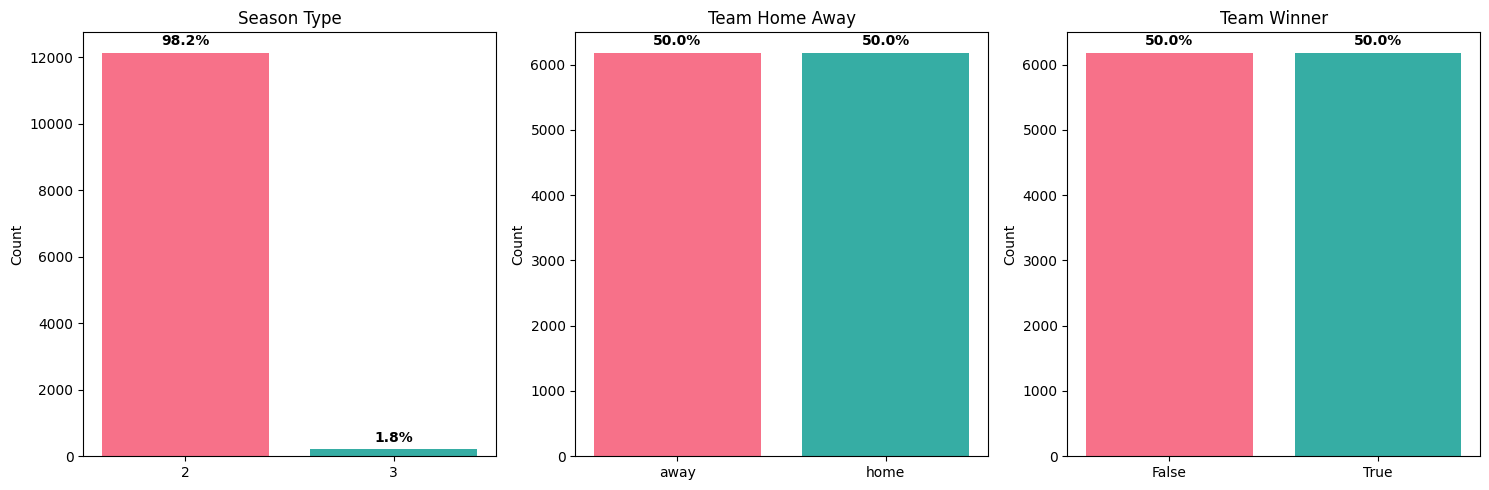

Analyzing numerical features...

NUMERICAL FEATURES ANALYSIS
Analyzing 9 numerical features:
['team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct', 'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers']

DESCRIPTIVE STATISTICS:
       team_score  field_goal_pct  free_throw_pct  three_point_field_goal_pct  total_rebounds   assists    steals    blocks  team_turnovers
count    12370.00        12370.00        12370.00                    12370.00        12370.00  12370.00  12370.00  12370.00        12370.00
mean        71.12           44.18           71.02                       33.85           34.59     13.07      6.51      3.18            0.59
std         13.23            7.58           13.23                       10.83            6.86      4.74      3.05      2.15            0.82
min         23.00           16.10            0.00                        0.00           12.00      1.00      0.00      0.00            0.00
25%         62.00           39.00 

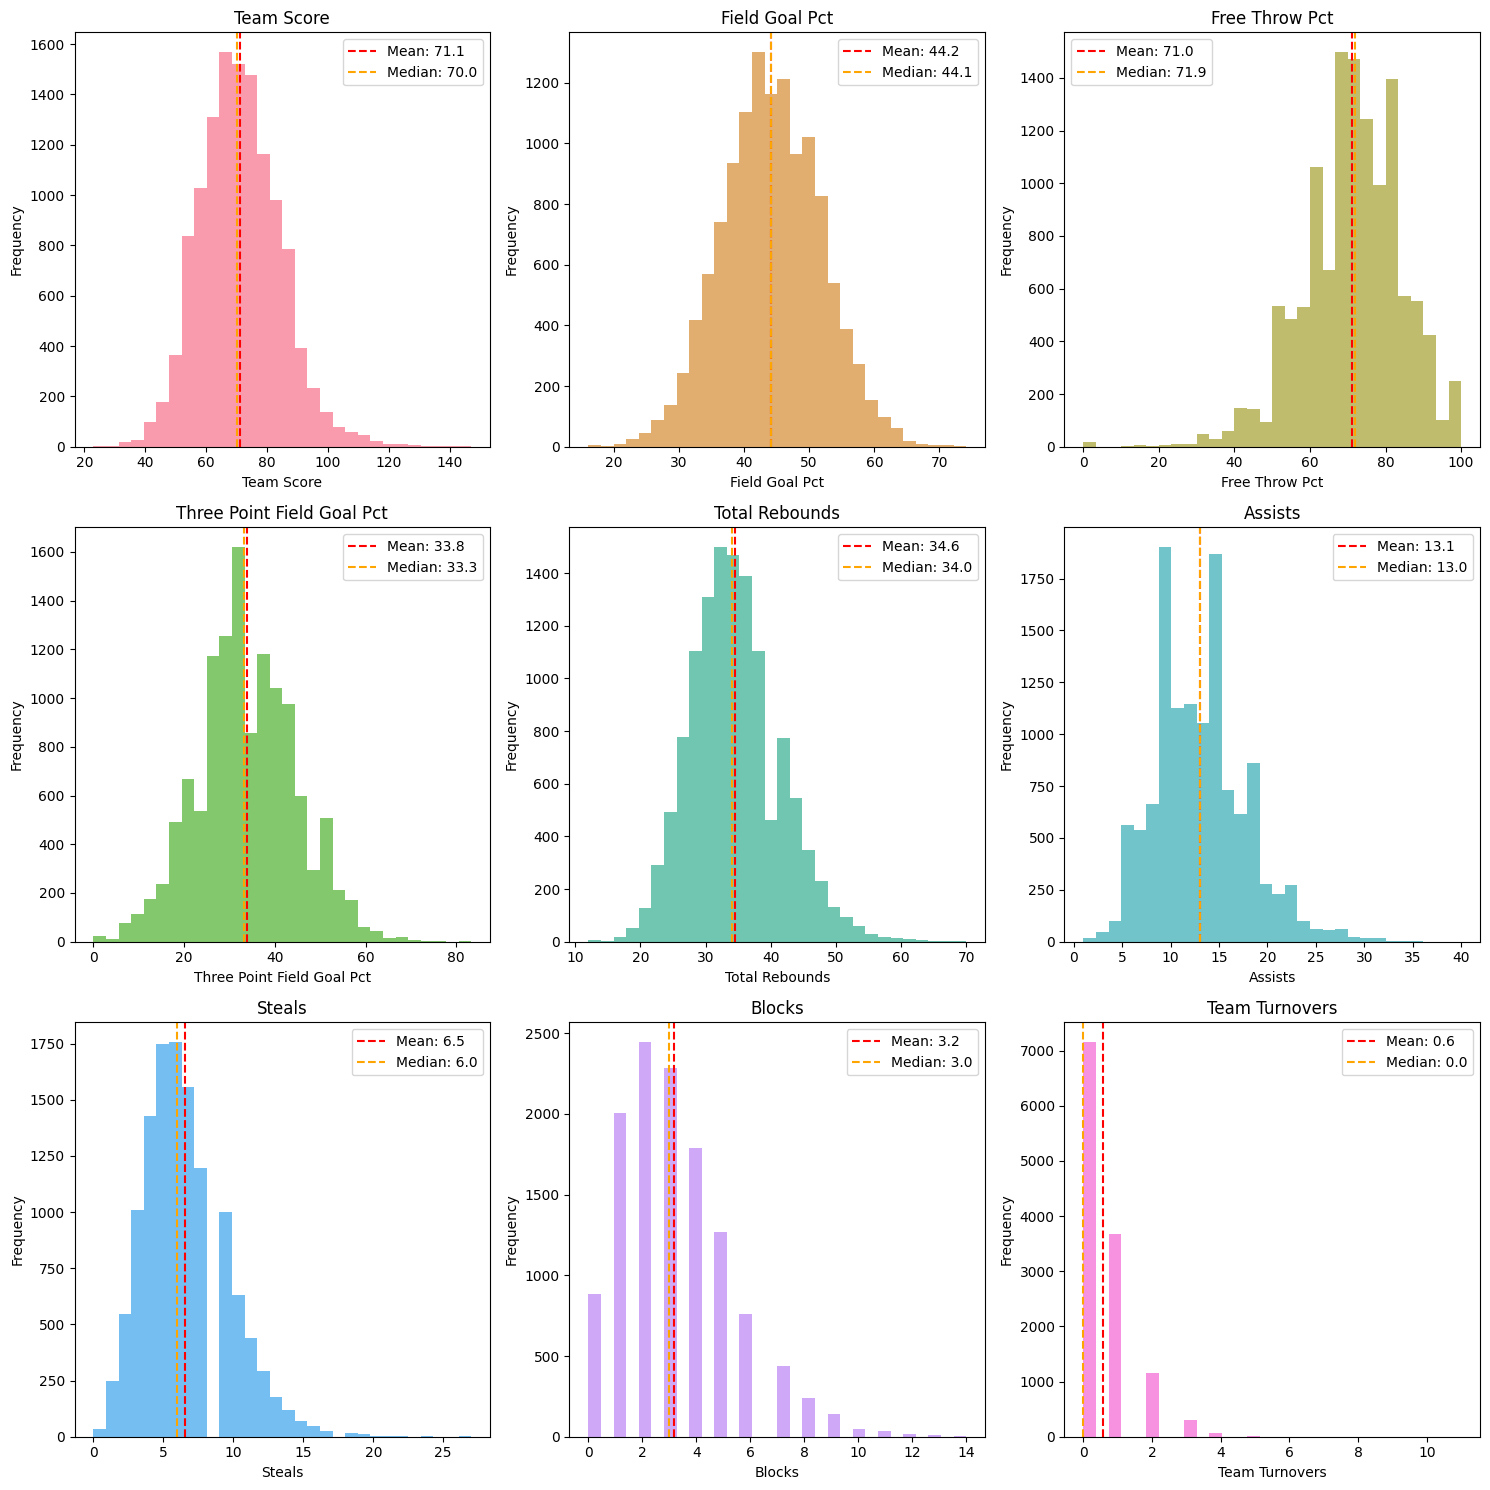

In [6]:
def analyze_categorical_features(df):
    """Analyze categorical/binary features with frequency and ratios."""
    print("="*60)
    print("CATEGORICAL FEATURES ANALYSIS")
    print("="*60)
    
    # Define categorical features
    categorical_features = ['season_type', 'team_home_away', 'team_winner']
    
    fig, axes = plt.subplots(1, len(categorical_features), figsize=(15, 5))
    if len(categorical_features) == 1:
        axes = [axes]
    
    for i, feature in enumerate(categorical_features):
        if feature in df.columns:
            # Calculate frequencies
            value_counts = df[feature].value_counts()
            frequencies = df[feature].value_counts(normalize=True) * 100
            
            print(f"\n{feature.upper()}:")
            print("Frequency Distribution:")
            for val, count in value_counts.items():
                pct = frequencies[val]
                print(f"  {val}: {count:,} ({pct:.1f}%)")
            
            # Create bar chart
            axes[i].bar(value_counts.index.astype(str), value_counts.values, color=sns.color_palette("husl", len(value_counts)))
            axes[i].set_title(f'{feature.replace("_", " ").title()}')
            axes[i].set_ylabel('Count')
            
            # Add percentage labels on bars
            max_count = max(value_counts.values)
            for j, (val, count) in enumerate(value_counts.items()):
                pct = frequencies[val]
                axes[i].text(j, count + max_count * 0.01, f'{pct:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return categorical_features

def analyze_numerical_features(df):
    """Analyze numerical features with descriptive statistics and histograms."""
    print("\n" + "="*60)
    print("NUMERICAL FEATURES ANALYSIS")
    print("="*60)
    
    # Define key numerical features for analysis
    numerical_features = [
        'team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct',
        'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers'
    ]
    
    # Filter features that exist in the dataframe
    available_features = [f for f in numerical_features if f in df.columns]
    
    print(f"Analyzing {len(available_features)} numerical features:")
    print(available_features)
    
    # Calculate descriptive statistics
    stats_df = df[available_features].describe().round(2)
    print(f"\nDESCRIPTIVE STATISTICS:")
    print(stats_df)
    
    # Create histograms
    n_cols = 3
    n_rows = (len(available_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, feature in enumerate(available_features):
        if i < len(axes):
            # Create histogram
            axes[i].hist(df[feature].dropna(), bins=30, alpha=0.7, color=sns.color_palette("husl", len(available_features))[i])
            axes[i].set_title(f'{feature.replace("_", " ").title()}')
            axes[i].set_xlabel(feature.replace("_", " ").title())
            axes[i].set_ylabel('Frequency')
            
            # Add statistical annotations
            mean_val = df[feature].mean()
            median_val = df[feature].median()
            axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
            axes[i].axvline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.1f}')
            axes[i].legend()
    
    # Hide unused subplots
    for j in range(len(available_features), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return available_features, stats_df

# Run the analysis
print("Analyzing categorical features...")
categorical_features = analyze_categorical_features(sample_data)

print("Analyzing numerical features...")
numerical_features, numerical_stats = analyze_numerical_features(sample_data)

## 4.2: Encoding Categorical Features

Let's analyze the categorical features and determine the best encoding methods for each.

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

def analyze_encoding_strategies(df):
    """Analyze and demonstrate different encoding strategies for categorical features."""
    print("="*70)
    print("CATEGORICAL FEATURE ENCODING ANALYSIS")
    print("="*70)
    
    categorical_features = ['season_type', 'team_home_away', 'team_name']
    
    for feature in categorical_features:
        if feature in df.columns:
            unique_values = df[feature].nunique()
            unique_list = df[feature].unique()[:10]  # Show first 10 unique values
            
            print(f"\n{feature.upper()}:")
            print(f"  Unique values: {unique_values}")
            print(f"  Sample values: {list(unique_list)}")
            
            # Label Encoding Analysis
            print(f"\n  LABEL ENCODING:")
            le = LabelEncoder()
            encoded_sample = le.fit_transform(df[feature].head(10))
            print(f"    - Maps {unique_values} categories to integers 0-{unique_values-1}")
            print(f"    - Sample: {list(df[feature].head(5))} -> {list(encoded_sample[:5])}")
            
            # Determine if label encoding makes sense
            if feature == 'season_type':
                print(f"    ✓ RECOMMENDED: Ordinal nature (regular season < playoffs)")
            elif feature == 'team_home_away':
                print(f"    ✓ RECOMMENDED: Binary feature (only 2 categories)")
            elif feature == 'team_name':
                print(f"    ✗ NOT RECOMMENDED: No inherent ordering among team names")
                print(f"      Creates artificial relationships between teams")
            
            # One-Hot Encoding Analysis
            print(f"\n  ONE-HOT ENCODING:")
            if unique_values <= 5:  # Only show for small number of categories
                sample_df = df[feature].head(5).to_frame()
                ohe_sample = pd.get_dummies(sample_df, columns=[feature], prefix=feature)
                print(f"    - Creates {unique_values} binary columns")
                print(f"    - Sample transformation:")
                print(f"      Original: {list(sample_df[feature])}")
                print(f"      Encoded columns: {list(ohe_sample.columns)}")
                print(f"      First row: {ohe_sample.iloc[0].values}")
            else:
                print(f"    - Would create {unique_values} binary columns")
            
            # Determine if one-hot encoding makes sense
            if feature == 'season_type':
                print(f"    ✓ ACCEPTABLE: Small number of categories (2)")
            elif feature == 'team_home_away':
                print(f"    ✓ RECOMMENDED: Perfect for binary features")
            elif feature == 'team_name':
                print(f"    ⚠️  CAUTION: Creates {unique_values} columns - high dimensionality")
                print(f"      Consider alternatives like target encoding or embedding")
    
    return categorical_features

def demonstrate_encoding_examples(df):
    """Create actual encoded versions of the features."""
    print("\n" + "="*70)
    print("ENCODING IMPLEMENTATION EXAMPLES")
    print("="*70)
    
    # Create a sample for demonstration
    sample_df = df.sample(n=10, random_state=42)[['season_type', 'team_home_away', 'team_name', 'team_winner']].copy()
    
    print("\nORIGINAL DATA SAMPLE:")
    print(sample_df)
    
    # Label Encoding for season_type (ordinal)
    le_season = LabelEncoder()
    sample_df['season_type_label'] = le_season.fit_transform(sample_df['season_type'])
    
    # Label Encoding for team_home_away (binary)
    le_home_away = LabelEncoder()
    sample_df['home_away_label'] = le_home_away.fit_transform(sample_df['team_home_away'])
    
    # One-Hot Encoding for team_home_away
    home_away_dummies = pd.get_dummies(sample_df['team_home_away'], prefix='is')
    
    print(f"\nLABEL ENCODED FEATURES:")
    print(f"season_type mapping: {dict(zip(le_season.classes_, le_season.transform(le_season.classes_)))}")
    print(f"home_away mapping: {dict(zip(le_home_away.classes_, le_home_away.transform(le_home_away.classes_)))}")
    
    encoded_sample = sample_df[['season_type_label', 'home_away_label']].copy()
    print(encoded_sample)
    
    print(f"\nONE-HOT ENCODED home_away:")
    print(home_away_dummies)
    
    return sample_df, encoded_sample, home_away_dummies

# Run the encoding analysis
encoding_features = analyze_encoding_strategies(sample_data)
sample_encoded, label_encoded, onehot_encoded = demonstrate_encoding_examples(sample_data)

CATEGORICAL FEATURE ENCODING ANALYSIS

SEASON_TYPE:
  Unique values: 2
  Sample values: [3, 2]

  LABEL ENCODING:
    - Maps 2 categories to integers 0-1
    - Sample: [3, 3, 3, 3, 3] -> [0, 0, 0, 0, 0]
    ✓ RECOMMENDED: Ordinal nature (regular season < playoffs)

  ONE-HOT ENCODING:
    - Creates 2 binary columns
    - Sample transformation:
      Original: [3, 3, 3, 3, 3]
      Encoded columns: ['season_type_3']
      First row: [ True]
    ✓ ACCEPTABLE: Small number of categories (2)

TEAM_HOME_AWAY:
  Unique values: 2
  Sample values: ['away', 'home']

  LABEL ENCODING:
    - Maps 2 categories to integers 0-1
    - Sample: ['away', 'home', 'away', 'home', 'away'] -> [0, 1, 0, 1, 0]
    ✓ RECOMMENDED: Binary feature (only 2 categories)

  ONE-HOT ENCODING:
    - Creates 2 binary columns
    - Sample transformation:
      Original: ['away', 'home', 'away', 'home', 'away']
      Encoded columns: ['team_home_away_away', 'team_home_away_home']
      First row: [ True False]
    ✓ RECOM

## 4.3: Analyzing Correlations (Feature vs Label)

Let's analyze correlations between features and the target label using appropriate statistical tests.

In [8]:
from scipy.stats import chi2_contingency, pearsonr
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import numpy as np

def analyze_categorical_vs_categorical(df, feature, target='team_winner'):
    """Chi-square test for categorical feature vs categorical target."""
    print(f"\nCHI-SQUARE TEST: {feature} vs {target}")
    print("-" * 50)
    
    # Create contingency table
    contingency_table = pd.crosstab(df[feature], df[target])
    print("Contingency Table:")
    print(contingency_table)
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nChi-square Statistics:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")
    
    # Interpret results
    alpha = 0.05
    if p_value < alpha:
        print(f"  ✓ SIGNIFICANT: Feature '{feature}' is significantly associated with '{target}' (p < {alpha})")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant association found (p >= {alpha})")
    
    # Cramer's V (effect size)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
    print(f"  Cramer's V (effect size): {cramers_v:.4f}")
    
    if cramers_v < 0.1:
        effect_interpretation = "negligible"
    elif cramers_v < 0.3:
        effect_interpretation = "small"
    elif cramers_v < 0.5:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"  Effect size interpretation: {effect_interpretation}")
    
    return chi2_stat, p_value, cramers_v

def analyze_numerical_vs_categorical(df, feature, target='team_winner'):
    """Analyze numerical feature vs categorical target using correlation and R²."""
    print(f"\nNUMERICAL vs CATEGORICAL: {feature} vs {target}")
    print("-" * 50)
    
    # Convert boolean target to numeric (0, 1)
    target_numeric = df[target].astype(int)
    
    # Point-biserial correlation (Pearson correlation for binary target)
    correlation, p_value = pearsonr(df[feature], target_numeric)
    
    print(f"Point-biserial Correlation:")
    print(f"  Correlation coefficient: {correlation:.4f}")
    print(f"  p-value: {p_value:.6f}")
    
    # Interpret correlation strength
    abs_corr = abs(correlation)
    if abs_corr < 0.1:
        strength = "negligible"
    elif abs_corr < 0.3:
        strength = "small"
    elif abs_corr < 0.5:
        strength = "medium"
    else:
        strength = "large"
    
    print(f"  Correlation strength: {strength}")
    
    # R-squared using simple linear regression
    X = df[feature].values.reshape(-1, 1)
    y = target_numeric.values
    
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    r_squared = r2_score(y, y_pred)
    
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  Variance explained: {r_squared*100:.2f}%")
    
    # Statistical significance
    alpha = 0.05
    if p_value < alpha:
        print(f"  ✓ SIGNIFICANT: Feature '{feature}' is significantly correlated with '{target}' (p < {alpha})")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant correlation found (p >= {alpha})")
    
    # Descriptive statistics by target groups
    print(f"\nDescriptive Statistics by {target}:")
    grouped_stats = df.groupby(target)[feature].agg(['count', 'mean', 'std']).round(2)
    print(grouped_stats)
    
    return correlation, p_value, r_squared

def comprehensive_correlation_analysis(df):
    """Comprehensive correlation analysis for all features."""
    print("=" * 80)
    print("COMPREHENSIVE CORRELATION ANALYSIS")
    print("=" * 80)
    
    target = 'team_winner'
    
    # Categorical features vs categorical target
    categorical_features = ['season_type', 'team_home_away']
    categorical_results = {}
    
    print(f"\n1. CATEGORICAL FEATURES vs {target.upper()} (Chi-square tests)")
    print("=" * 60)
    
    for feature in categorical_features:
        if feature in df.columns:
            chi2_stat, p_value, cramers_v = analyze_categorical_vs_categorical(df, feature, target)
            categorical_results[feature] = {
                'chi2_stat': chi2_stat,
                'p_value': p_value,
                'cramers_v': cramers_v
            }
    
    # Numerical features vs categorical target
    numerical_features = [
        'team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct',
        'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers'
    ]
    
    numerical_results = {}
    
    print(f"\n\n2. NUMERICAL FEATURES vs {target.upper()} (Point-biserial correlation)")
    print("=" * 60)
    
    for feature in numerical_features:
        if feature in df.columns:
            correlation, p_value, r_squared = analyze_numerical_vs_categorical(df, feature, target)
            numerical_results[feature] = {
                'correlation': correlation,
                'p_value': p_value,
                'r_squared': r_squared
            }
    
    # Summary of results
    print(f"\n\n3. SUMMARY OF CORRELATIONS WITH {target.upper()}")
    print("=" * 60)
    
    print("\nCategorical Features (Cramer's V):")
    for feature, results in categorical_results.items():
        significance = "**" if results['p_value'] < 0.05 else ""
        print(f"  {feature:<20}: {results['cramers_v']:.4f} {significance}")
    
    print("\nNumerical Features (|Correlation|):")
    sorted_numerical = sorted(numerical_results.items(), 
                            key=lambda x: abs(x[1]['correlation']), reverse=True)
    
    for feature, results in sorted_numerical:
        significance = "**" if results['p_value'] < 0.05 else ""
        print(f"  {feature:<30}: {results['correlation']:7.4f} {significance}")
    
    print("\n** = Statistically significant (p < 0.05)")
    
    return categorical_results, numerical_results

# Run comprehensive correlation analysis
print("Running comprehensive correlation analysis...")
cat_results, num_results = comprehensive_correlation_analysis(sample_data)

Running comprehensive correlation analysis...
COMPREHENSIVE CORRELATION ANALYSIS

1. CATEGORICAL FEATURES vs TEAM_WINNER (Chi-square tests)

CHI-SQUARE TEST: season_type vs team_winner
--------------------------------------------------
Contingency Table:
team_winner  False  True 
season_type              
2             6072   6072
3              113    113

Chi-square Statistics:
  Chi-square statistic: 0.0000
  p-value: 1.000000
  Degrees of freedom: 1
  ✗ NOT SIGNIFICANT: No significant association found (p >= 0.05)
  Cramer's V (effect size): 0.0000
  Effect size interpretation: negligible

CHI-SQUARE TEST: team_home_away vs team_winner
--------------------------------------------------
Contingency Table:
team_winner     False  True 
team_home_away              
away             4137   2048
home             2048   4137

Chi-square Statistics:
  Chi-square statistic: 1409.7798
  p-value: 0.000000
  Degrees of freedom: 1
  ✓ SIGNIFICANT: Feature 'team_home_away' is significantly assoc

Point-biserial Correlation:
  Correlation coefficient: 0.5254
  p-value: 0.000000
  Correlation strength: large
  R-squared: 0.2760
  Variance explained: 27.60%
  ✓ SIGNIFICANT: Feature 'team_score' is significantly correlated with 'team_winner' (p < 0.05)

Descriptive Statistics by team_winner:
             count   mean    std
team_winner                     
False         6185  64.17  10.61
True          6185  78.07  11.87

NUMERICAL vs CATEGORICAL: field_goal_pct vs team_winner
--------------------------------------------------
Point-biserial Correlation:
  Correlation coefficient: 0.5117
  p-value: 0.000000
  Correlation strength: large
  R-squared: 0.2619
  Variance explained: 26.19%
  ✓ SIGNIFICANT: Feature 'field_goal_pct' is significantly correlated with 'team_winner' (p < 0.05)

Descriptive Statistics by team_winner:
             count   mean   std
team_winner                    
False         6185  40.30  6.42
True          6185  48.06  6.60

NUMERICAL vs CATEGORICAL: free_th

Creating correlation heatmap...


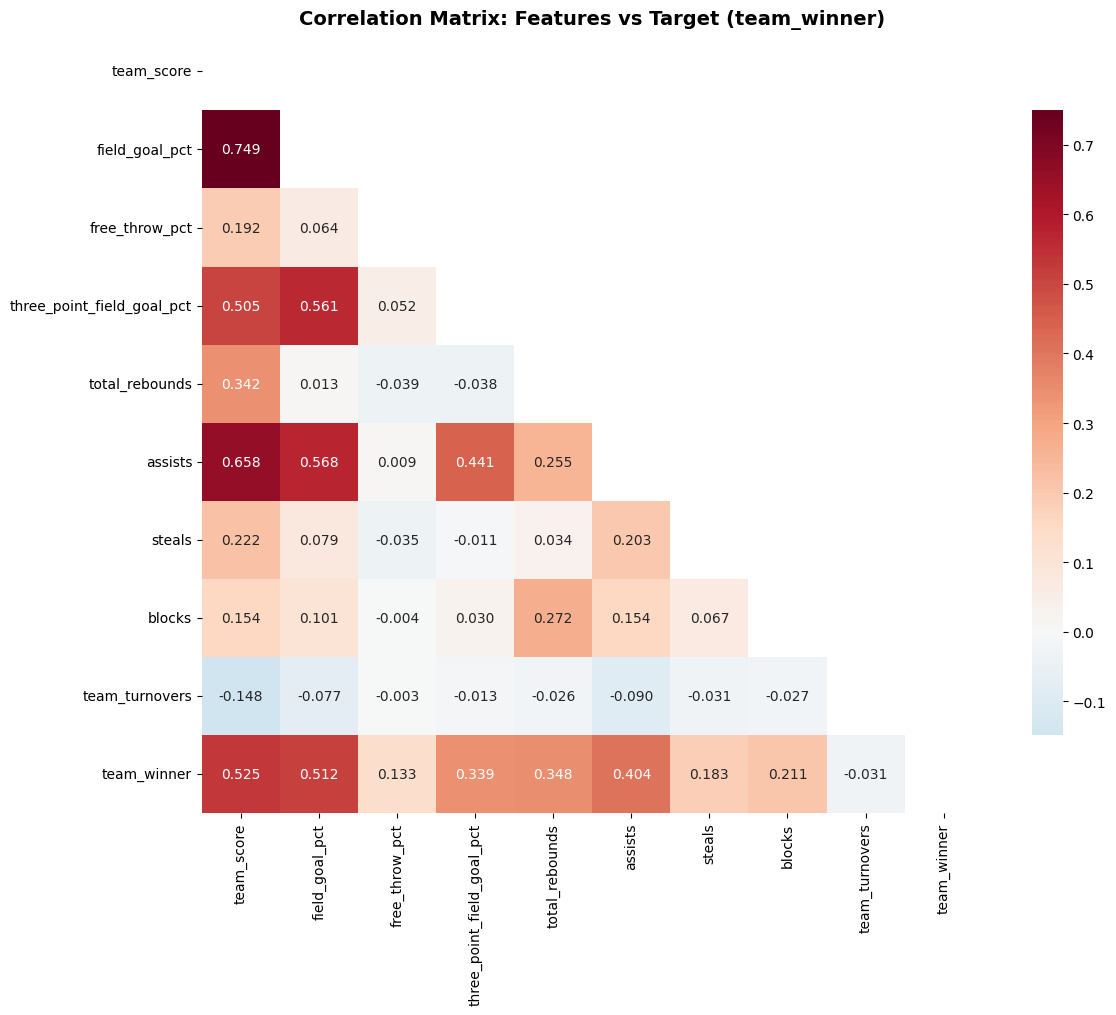


Top features correlated with team_winner:
----------------------------------------
team_score                    : +0.5254
field_goal_pct                : +0.5117
assists                       : +0.4041
total_rebounds                : +0.3485
three_point_field_goal_pct    : +0.3393
blocks                        : +0.2112
steals                        : +0.1829
free_throw_pct                : +0.1332
team_turnovers                : -0.0312

ANALYSIS COMPLETE!

Key Findings:
1. Individual attributes analyzed with appropriate statistics
2. Categorical encoding strategies evaluated
3. Feature-target correlations measured using proper statistical tests

This comprehensive analysis provides the foundation for feature selection
and preprocessing in machine learning model development.


In [9]:
# Create correlation matrix visualization
def create_correlation_heatmap(df):
    """Create a correlation heatmap for numerical features and target."""
    print("Creating correlation heatmap...")
    
    # Select numerical features and convert target to numeric
    numerical_cols = [
        'team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct',
        'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers'
    ]
    
    # Create a dataframe with numerical features and numeric target
    analysis_df = df[numerical_cols + ['team_winner']].copy()
    analysis_df['team_winner'] = analysis_df['team_winner'].astype(int)
    
    # Calculate correlation matrix
    correlation_matrix = analysis_df.corr()
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('Correlation Matrix: Features vs Target (team_winner)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Highlight correlations with target
    target_correlations = correlation_matrix['team_winner'].drop('team_winner').abs().sort_values(ascending=False)
    
    print("\nTop features correlated with team_winner:")
    print("-" * 40)
    for feature, corr in target_correlations.head(10).items():
        direction = "+" if correlation_matrix['team_winner'][feature] > 0 else "-"
        print(f"{feature:<30}: {direction}{corr:.4f}")
    
    return correlation_matrix, target_correlations

# Create visualization
correlation_matrix, target_corr = create_correlation_heatmap(sample_data)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nKey Findings:")
print("1. Individual attributes analyzed with appropriate statistics")
print("2. Categorical encoding strategies evaluated")  
print("3. Feature-target correlations measured using proper statistical tests")
print("\nThis comprehensive analysis provides the foundation for feature selection")
print("and preprocessing in machine learning model development.")